In [1]:
import os
from dotenv import load_dotenv
from datasets import load_dataset, DatasetDict
import torch
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
from torchvision import transforms
import matplotlib.pyplot as plt

#### https://www.kaggle.com/datasets/asaniczka/mammals-image-classification-dataset-45-animals/

#### Setting up some constants (loading from .env file)

In [2]:
load_dotenv()

SEED = int(os.getenv('SEED'))
IMAGES_DATASET_RAW_PATH = os.getenv('IMAGES_DATASET_RAW_PATH')
TEXT_DATASET_RAW_PATH = os.getenv('TEXT_DATASET_RAW_PATH')

if not os.path.exists(IMAGES_DATASET_RAW_PATH):
    os.makedirs(IMAGES_DATASET_RAW_PATH)

if not os.path.exists(TEXT_DATASET_RAW_PATH):
    os.makedirs(TEXT_DATASET_RAW_PATH)

#### Images dataset
Based on kaggle description:
-    Total number of classes: 45
-    Total number of images: 13751
-    Resolution: 256x256 pixels
-    Image format: JPG

In [3]:
dataset = ImageFolder(IMAGES_DATASET_RAW_PATH)

In [4]:
dataset

Dataset ImageFolder
    Number of datapoints: 13751
    Root location: ../data/images/raw

In [5]:
print(f'Classes: {dataset.classes}')
print(f'Number of classes: {len(dataset.classes)}')

Classes: ['african_elephant', 'alpaca', 'american_bison', 'anteater', 'arctic_fox', 'armadillo', 'baboon', 'badger', 'blue_whale', 'brown_bear', 'camel', 'dolphin', 'giraffe', 'groundhog', 'highland_cattle', 'horse', 'jackal', 'kangaroo', 'koala', 'manatee', 'mongoose', 'mountain_goat', 'opossum', 'orangutan', 'otter', 'polar_bear', 'porcupine', 'red_panda', 'rhinoceros', 'sea_lion', 'seal', 'snow_leopard', 'squirrel', 'sugar_glider', 'tapir', 'vampire_bat', 'vicuna', 'walrus', 'warthog', 'water_buffalo', 'weasel', 'wildebeest', 'wombat', 'yak', 'zebra']
Number of classes: 45


In [6]:
class_to_id = dataset.class_to_idx
id_to_class = {v: k for k, v in class_to_id.items()}
id_to_class

{0: 'african_elephant',
 1: 'alpaca',
 2: 'american_bison',
 3: 'anteater',
 4: 'arctic_fox',
 5: 'armadillo',
 6: 'baboon',
 7: 'badger',
 8: 'blue_whale',
 9: 'brown_bear',
 10: 'camel',
 11: 'dolphin',
 12: 'giraffe',
 13: 'groundhog',
 14: 'highland_cattle',
 15: 'horse',
 16: 'jackal',
 17: 'kangaroo',
 18: 'koala',
 19: 'manatee',
 20: 'mongoose',
 21: 'mountain_goat',
 22: 'opossum',
 23: 'orangutan',
 24: 'otter',
 25: 'polar_bear',
 26: 'porcupine',
 27: 'red_panda',
 28: 'rhinoceros',
 29: 'sea_lion',
 30: 'seal',
 31: 'snow_leopard',
 32: 'squirrel',
 33: 'sugar_glider',
 34: 'tapir',
 35: 'vampire_bat',
 36: 'vicuna',
 37: 'walrus',
 38: 'warthog',
 39: 'water_buffalo',
 40: 'weasel',
 41: 'wildebeest',
 42: 'wombat',
 43: 'yak',
 44: 'zebra'}

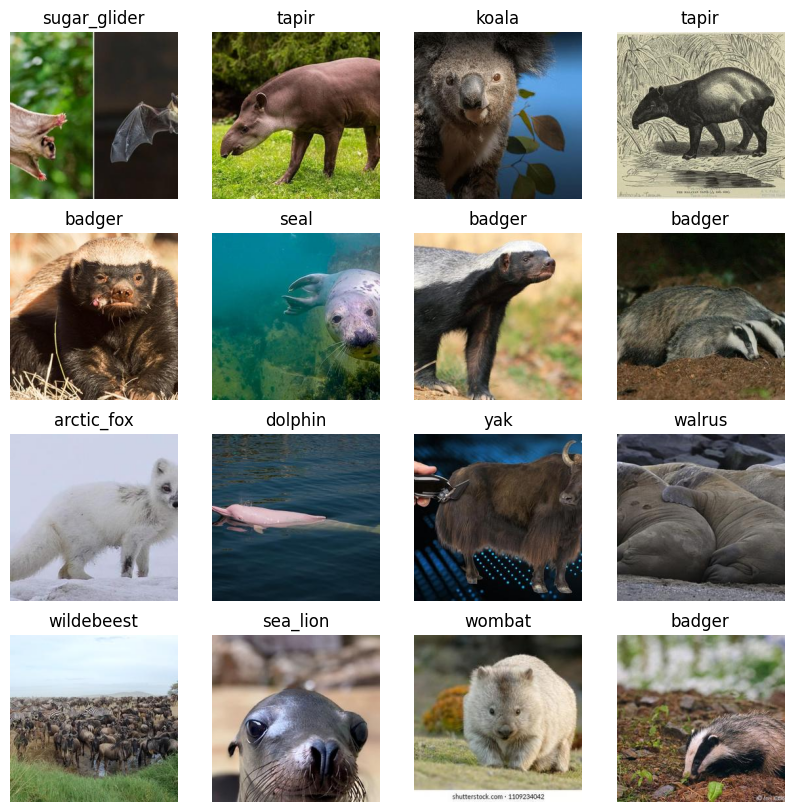

In [7]:
def show_image(dataset: Dataset, num_images: int=16, rows: int=4, figsize: tuple[int,int]=(10, 10)) -> None:
    '''
    Show a random sample of images from the dataset
    
    Args:
        dataset (Dataset): The dataset to show images from
        num_images (int): The number of images to show
        rows (int): The number of rows to show the images in
        figsize (tuple[int,int]): The size of the figure
    '''
    images = []
    labels = []
    for i in range(num_images):
        randint = torch.randint(0, len(dataset), (1,)).item()
        image, label = dataset[randint]
        images.append(image)
        labels.append(id_to_class[label])

    plt.figure(figsize=figsize)
    cols = num_images // rows
    for i in range(num_images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i])
        plt.title(labels[i])
        plt.axis('off')
    plt.show()

show_image(dataset)

#### Let's check images ditribution by class

In [8]:
counts = {k: 0 for k in range(len(dataset.classes))}
for k, v in counts.items():
    counts[k] = dataset.targets.count(k)

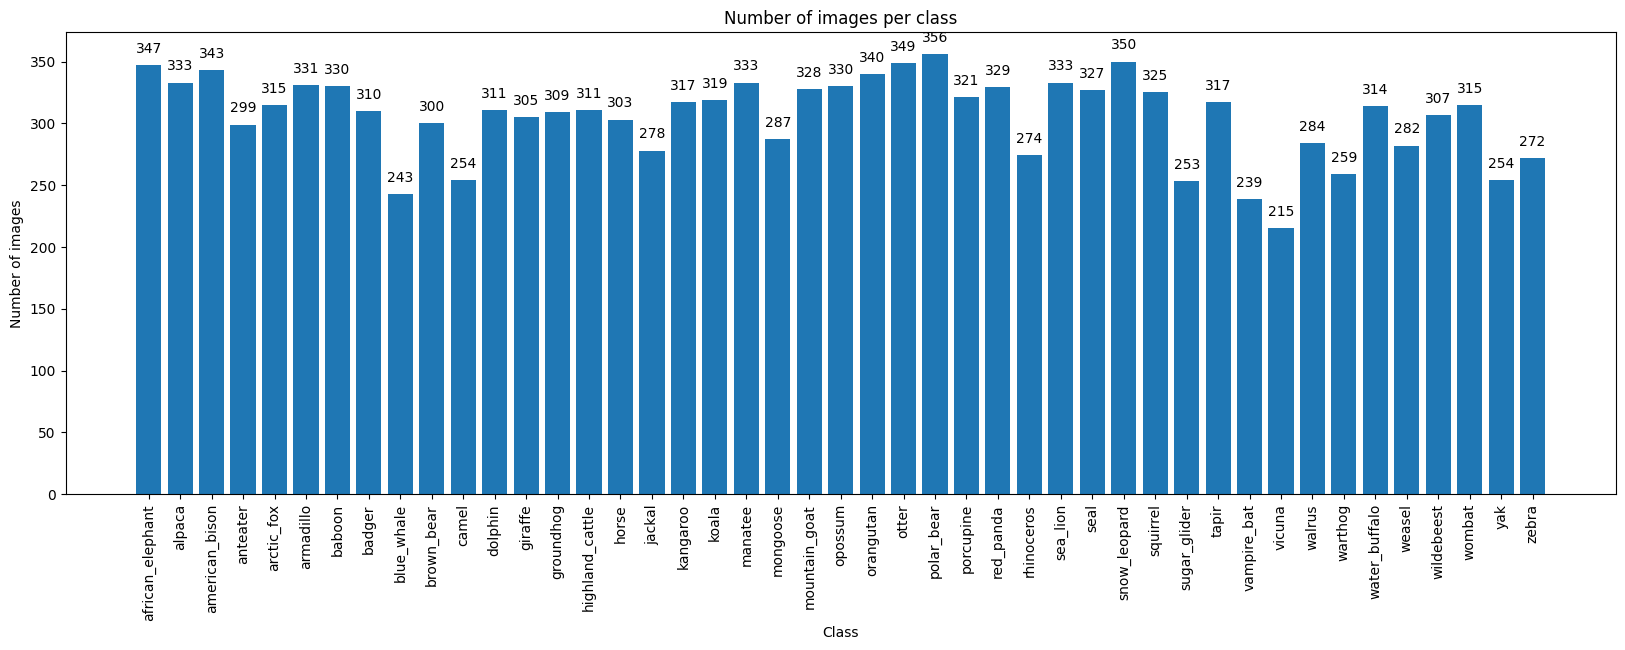

In [9]:
plt.figure(figsize=(20, 6))
plt.bar(id_to_class.values(), counts.values())
plt.ylabel('Number of images')
plt.xlabel('Class')
plt.title('Number of images per class')
plt.xticks(rotation=90)
for i, v in enumerate(counts.values()):
    plt.text(i, v + 10, str(v), ha='center')
plt.show()

There are some classes with less images than the others, but there are still enough images in each class to train a model.

#### Text dataset
It has 2 columns: `tokens` and `tags`, where `tokens` is a list of words and `tags` is a list of tag-ids for each word (0 - non animal, 1 - animal).

Lets generate some artificial data for NER model

In [10]:
import json
import random

# List of animal names
animals = [cls.replace('_',' ') for cls in dataset.classes]

# Sample sentence structures with placeholders
sentence_templates = [
    "The {} is a fascinating animal found in various parts of the world.",
    "Scientists have studied the {} for decades to understand its behavior.",
    "{} populations have been decreasing due to habitat destruction.",
    "In some cultures, the {} is considered a symbol of strength.",
    "Unlike many other mammals, the {} thrives in extreme conditions.",
    "The zoo recently welcomed a newborn {}, attracting many visitors.",
    "During migration, {} travel long distances in search of food.",
    "Conservationists are working hard to protect the endangered {}!",
    "A group of {} can often be seen roaming the grasslands.",
    "{} are known for their distinctive features and unique adaptations.",
    "Did you know that the {} has one of the longest lifespans?",
    "Famous nature documentaries have captured stunning footage of {} in the wild.",
    "The {} is often mistaken for a similar-looking species, but it has key differences.",
    "Some species of {} have been domesticated for agricultural purposes.",
    "{} are often depicted in folklore and mythology around the world.",
    "The {} has a thick coat that helps it survive in cold climates.",
    "Young {} rely on their mothers for protection and nourishment.",
    "Scientists believe that the {} has evolved unique survival tactics.",
    "{} are excellent swimmers and can stay underwater for extended periods.",
    "Despite its appearance, the {} is not closely related to other similar-looking animals.",
    "The {} is a fascinating animal found in various parts of the world. It is known for its distinctive features and unique adaptations.",
    "Scientists have studied the {} for decades to understand its behavior. They have discovered many interesting facts about this species.",
    "{} populations have been decreasing due to habitat destruction. Conservationists are working hard to protect the endangered species.",
    "In some cultures, the {} is considered a symbol of strength. It has been featured in many myths and legends.",
    "Unlike many other mammals, the {} thrives in extreme conditions. It has evolved unique survival tactics to survive in harsh environments.",
    "The zoo recently welcomed a newborn {}, attracting many visitors. The baby animal is healthy and growing quickly.",
    "During migration, {} travel long distances in search of food. They rely on their instincts to guide them on their journey.",
    "Conservationists are working hard to protect the endangered {}. They are implementing strategies to increase the species' population.",
    "A group of {} can often be seen roaming the grasslands. They graze on grass and other vegetation to meet their dietary needs.",
    "{} are known for their distinctive features and unique adaptations. These characteristics help them thrive in their natural habitats.",
    "The {} and the {} are two of the most iconic animals in the world.",
    "Humans and {} have coexisted for thousands of years.",
    "Jane observed the {} and the {} in their natural habitat.",
    "There was a sighting of a {} and a {} near the Colorado River.",
    "There are a lot of {} in the New York City zoo.",
    "The {} and the {} are often mistaken for each other due to their similar appearance.",
    "The {} and the {} are two of the most fascinating creatures on Earth.",
    "Police caught a thief who was trying to steal a {} from the zoo on Brighton Street.",
    "It was stated by Mark that the {} and the {} are the most beautiful animals in the world.",
    "{} are Jake's favorite animals since he was a child.",
]


def split_punctuation(tokens):
    '''
    Split punctuation marks from tokens
    
    Args:
        tokens (list): List of tokens
        
    Returns:
        list: List of tokens with punctuation marks separated
    '''
    new_tokens = []
    for token in tokens:
        if token.endswith(('!', '?', '.', ',')):
            new_tokens.append(token[:-1])
            new_tokens.append(token[-1])
        else:
            new_tokens.append(token)
    
    return new_tokens

# Generate dataset
animals_json = []

for animal in animals:
    for sentence_template in sentence_templates:
        # Fill in placeholder with animal name or names
        second_animal = random.choice(animals)
        if sentence_template.count('{}') == 1:
            sentence = sentence_template.format(animal)
        else:
            sentence = sentence_template.format(animal, second_animal)

        # Tokenize sentence
        tokens = sentence.split()

        # split punctuation marks
        tokens = split_punctuation(tokens)

        # Generate tags (1 for animal names beginning, 2 for continuations, 0 otherwise)
        tags = [1 if token.lower() in animal.lower().split() or token.lower() in second_animal.lower().split() else 0 for token in tokens]
        
        for i, tag in enumerate(tags):
            if tag == 1:
                if i > 0 and tags[i - 1] == 1:
                    tags[i] = 2

        animals_json.append({'tokens': tokens,'tags': tags})

# add some sentences with no animal names
sentences_no_animal = [
    "Mark observed the stars through his telescope.",
    "The weather forecast predicts rain showers this weekend.",
    "The new exhibit at the museum features contemporary art.",
    "The company plans to launch a new product next month.",
    "The chef prepared a delicious meal for the guests.",
    "The children played in the park until sunset.",
    "The latest fashion trends include bold colors and patterns.",
    "The team worked together to complete the project ahead of schedule.",
    "The students conducted experiments to test their hypotheses.",
    "The book club meets every Tuesday to discuss the latest novel.",
    "The movie received positive reviews from critics and audiences.",
    "The garden is blooming with colorful flowers and plants.",
    "The orchestra performed a selection of classical and modern pieces.",
    "The city council approved the new budget for the upcoming fiscal year.",
    "The volunteers helped clean up the beach after the storm.",
    "The technology company announced a breakthrough in artificial intelligence.",
    "The athletes trained hard to prepare for the upcoming competition.",
    "The researchers analyzed the data to draw meaningful conclusions.",
    "The concert was a success, with thousands of fans in attendance.",
    "The family gathered for a reunion to celebrate the holidays.",
    "The detective solved the case after months of investigation.",
    "The artist painted a mural on the side of the building.",
    "The community came together to support those in need.",
    "The mountain range is home to a diverse array of wildlife.",
    "The entrepreneur launched a startup company in the tech industry.",
    "The medical team treated patients with care and compassion.",
    "The political candidate outlined their platform for the upcoming election.",
    "The museum exhibit showcases artifacts from ancient civilizations.",
    "The author published a new book that became a bestseller.",
    "The theater company performed a classic play for the audience.",
    "The charity organization raised funds to support local initiatives.",
    "The scientist conducted experiments to test their hypothesis.",
    "The art gallery features a collection of contemporary works.",
    "The film director won an award for their latest movie.",
    "The wildlife sanctuary provides a safe haven for endangered species.",
    "The technology company developed a new app for smartphones.",
    "The students presented their research findings at the conference.",
    "The music festival featured a lineup of popular bands and artists.",
    "The community center offers programs for people of all ages.",
    "The environmental group organized a cleanup of the local park.",
    "The fashion designer launched a new line of clothing for the season.",
    "The team of scientists discovered a new species of plant.",
]

for sentence in sentences_no_animal:
    tokens = sentence.split()
    tokens = split_punctuation(tokens)
    tags = [0] * len(tokens)
    animals_json.append({'tokens': tokens,'tags': tags})

In [11]:
# Shuffle dataset
random.seed(SEED)
random.shuffle(animals_json)
test_split = int(0.2 * len(animals_json))
train_data = animals_json[:-test_split]
test_data = animals_json[-test_split:]
print(f'Train samples: {len(train_data)}')
print(f'Test samples: {len(test_data)}')

Train samples: 1474
Test samples: 368


In [12]:
# Save dataset to JSON files
dataset_path_train = os.path.join(TEXT_DATASET_RAW_PATH, 'animal_ner_dataset_train.json')
dataset_path_test = os.path.join(TEXT_DATASET_RAW_PATH, 'animal_ner_dataset_test.json')
with open(dataset_path_train, 'w') as f:
    json.dump(train_data, f, indent=4)

with open(dataset_path_test, 'w') as f:
    json.dump(test_data, f, indent=4)

In [13]:
# Load dataset from JSON files
text_ds = load_dataset('json', data_files={'train': dataset_path_train, 'test': dataset_path_test})
text_ds

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 1474
    })
    test: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 368
    })
})

In [14]:
sample_num = torch.randint(0, len(text_ds['train']), (1,)).item()
for tokens, tags in zip(text_ds['train'][sample_num]['tokens'], text_ds['train'][sample_num]['tags']):
    print(tokens, tags)

In 0
some 0
cultures 0
, 0
the 0
sea 1
lion 2
is 0
considered 0
a 0
symbol 0
of 0
strength 0
. 0


#### Let's check the distribution of tags

In [15]:
def animals_distribution(ds):
    '''
    Function to calculate the distribution of animals in the dataset
    
    Args:
        ds (datasets.Dataset): dataset to calculate the distribution

    Returns:
        (int, int): total number of animals in the dataset, total number of tokens in the dataset
    '''
    total_tokens = 0
    total_animals = 0
    for sentence in ds:
        total_tokens += len(sentence['tags'])
        if 1 in sentence['tags']:
            total_animals += sentence['tags'].count(1)
    
    return total_animals, total_tokens

train_total_animals, train_total_tokens  = animals_distribution(text_ds['train'])
test_total_animals, test_total_tokens = animals_distribution(text_ds['test'])

In [16]:
print(f'Train dataset: {train_total_animals/train_total_tokens:.2%} of tokens are animals')
print(f'Test dataset: {test_total_animals/test_total_tokens:.2%} of tokens are animals')

Train dataset: 7.23% of tokens are animals
Test dataset: 6.92% of tokens are animals


#### Let's check length of tokens
Our sentences are small, so they will easily fit into the BERT model that we will use (max 512 tokens).

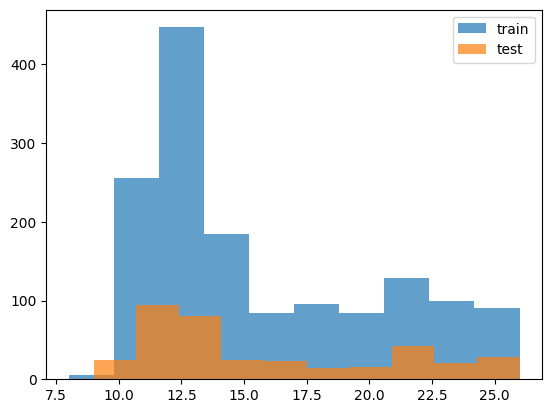

In [17]:
lengths_train = [len(example['tokens']) for example in text_ds['train']]
lengths_test = [len(example['tokens']) for example in text_ds['test']]

plt.hist(lengths_train, alpha=0.7, label='train')
plt.hist(lengths_test, alpha=0.7, label='test')
plt.legend()
plt.show()